In [8]:
using JLD2, XLSX, FASTX, DataFrames, StatsBase, Distributions, Printf, ProRF, Seaborn, PyPlot, Statistics

In [9]:
macro check()
    :(begin
    println(length.(error_vector))
    println("Ratio of error than α (%)")
    println((length.(error_vector) ./ n ./ a .- 1) .* 100)
    tot_error_vector = vcat(error_vector...)
    @printf "%d %d / %d\n" sum(length.(error_vector)) length(Set(tot_error_vector)) floor(Int, sum(length.(error_vector)) / 4)
    end)
end

function get_x(seq_vector::Vector{String}; convert::Union{String, Vector{String}, T, Vector{T}}="all") where T <: Dict{Char}
    if convert isa String || convert isa Vector{String}
        convert_dict = Dict{String, Dict{Char, Float64}}("vol" => ProRF.volume, "pI" => ProRF.pI, "hyd" => ProRF.hydrophobicity)
        if convert isa String
            if convert == "all"
                convert = Vector{String}(collect(keys(convert_dict)))
            else
                convert = Vector{String}([convert])
            end
        end

        convert_dict_keys = keys(convert_dict)
        for scon in convert
            if scon ∉ convert_dict_keys
                error("Please check the keyword: all, " * join(convert_dict_keys, ", "))
            end
        end

        convert = map(x -> convert_dict[x], convert)
    else
        convert = ProRF._convert_dict(convert)
    end

    test_vector = Vector{Vector{Float64}}()
    @views for seq in seq_vector
        push!(test_vector, vcat([[con[j] for con in convert] for j in seq]...))
    end
    return Matrix{Float64}(vcat(transpose.(test_vector)...))
end

@load "BigSave/sf3.jld2" data

1-element Vector{Symbol}:
 :data

In [10]:
excel_data = DataFrame(XLSX.readtable("Save/avGFP.xlsx", "Sheet1", infer_eltypes=true))
ref_seq = FASTA.sequence(String, first(open(FASTA.Reader, "Save/avGFP_ref.fasta")))
data_vector = Vector{Vector{Float64}}(collect(eachcol(data)));

In [11]:
length(excel_data[!, 2])

159845

In [12]:
ratio = 0.01
a = 0.05
n = floor(Int, ratio * length(data_vector[1]))
error_vector = Vector{Vector{Int}}()
for d in data_vector
    dif_rank = collect(1:n) .- tiedrank(d[1:n], rev=true)
    norm_dif_rank = (dif_rank .- mean(dif_rank)) ./ std(dif_rank)
    push!(error_vector, findall(x -> x > quantile(Normal(0, 1), 1-a/2), abs.(norm_dif_rank)))
end

In [13]:
@check

[83, 89, 81, 86]
Ratio of error than α (%)
[3.8798498122653235, 11.389236545682092, 1.3767209011264159, 7.634543178973718]
339 208 / 84


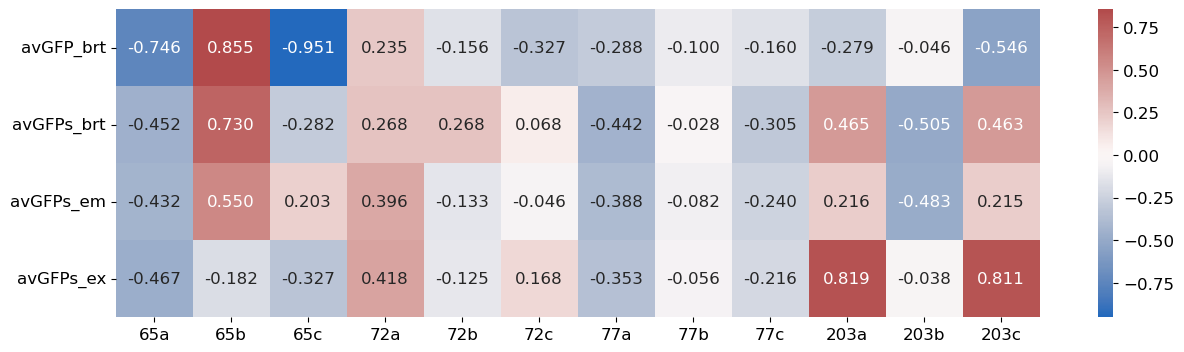

In [14]:
plt = matplotlib.pyplot
yloc = ["avGFP_brt", "avGFPs_em", "avGFPs_ex", "avGFPs_brt"]
yorder = [1, 4, 2, 3]
xloc = [65, 72, 77, 203]
xorder = [1, 2, 3, 4]
xtick = [s * i for s in string.(xloc[xorder]) for i in 'a':'c']

cor_vector = Vector{Vector{Float64}}()
for (e, d) in zip(error_vector, data_vector)
    X = get_x(map(x->excel_data[!, 2][x][xorder], e))
    push!(cor_vector, [cor(i, d[e]) for i in eachcol(X)])
end

plt.rcParams["font.family"] = "Arial"
plt.figure(figsize=(15, 4))
h = heatmap(cor_vector[yorder], annot=true, square=true, cmap="vlag", center=0, fmt=".3f", xticklabels=xtick, yticklabels=yloc[yorder], annot_kws=Dict("size" => 12))
h.collections[0].colorbar.ax.tick_params(labelsize=12)
h.yaxis.set_tick_params(labelsize=12)
h.xaxis.set_tick_params(labelsize=12)
savefig("Fig/f3-d1.tif", dpi=600, bbox_inches="tight")
display(gcf())
close("all")

In [15]:
vec(mean(reshape(mean(map(x->abs.(x), cor_vector)), (3, length(xorder))), dims=1))

4-element Vector{Float64}:
 0.514761322475315
 0.21727801724420845
 0.2214285929735759
 0.40718674795739335

In [21]:
t = mean(map(x->abs.(x), cor_vector))
println(t[4] / t[5])
println(t[4] / t[6])

1.930521172761991
2.1617372264662214


In [17]:
@load "Save/imp.jld2" L F L1 F1 L2 F2 L3 F3
l_vector = [L, L1, L2, L3]
f_vector = [F, F1, F2, F3];

In [18]:
xtick = [s * i for s in string.([65, 72, 203]) for i in 'a':'c']
imp_vector = [[f[findfirst(isequal(x), l)] for x in xtick] for (l, f) in zip(l_vector, f_vector)]
for i in eachindex(imp_vector)
    imp_vector[i] ./= minimum(imp_vector[i])
end

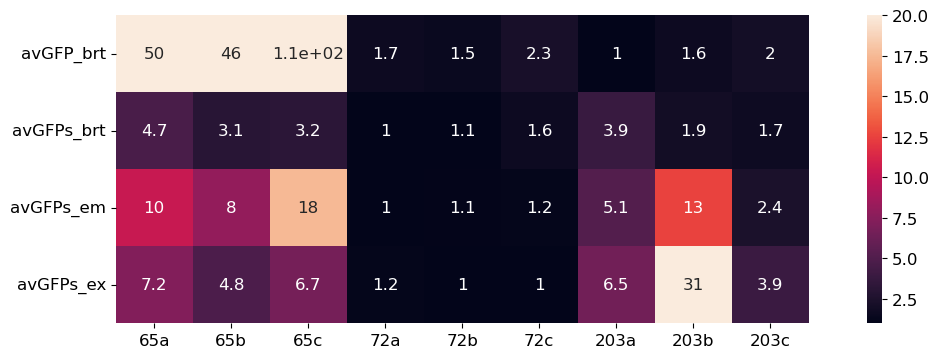

In [19]:
plt.rcParams["font.family"] = "Arial"
plt.figure(figsize=(15, 4))
h = heatmap(imp_vector[yorder], vmax=20, annot=true, square=true, xticklabels=xtick, yticklabels=yloc[yorder], annot_kws=Dict("size" => 12))
h.collections[0].colorbar.ax.tick_params(labelsize=12)
h.yaxis.set_tick_params(labelsize=12)
h.xaxis.set_tick_params(labelsize=12)
display(gcf())
close("all")